In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]: 


import time
import argparse
import numpy as np
import torch
from models.GCN import GCN
from models.GCN_Encoder import GCN_Encoder
from torch_geometric.datasets import Planetoid, WebKB, WikipediaNetwork,Reddit,Reddit2,Flickr,Yelp,PPI
from torch_geometric.utils import to_dense_adj,dense_to_sparse

from ogb.nodeproppred import PygNodePropPredDataset
# from torch_geometric.loader import DataLoader
from help_funcs import prune_unrelated_edge,prune_unrelated_edge_isolated,select_target_nodes
import help_funcs
import scipy.sparse as sp

# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--debug', action='store_true',
        default=True, help='debug mode')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=10, help='Random seed.')
parser.add_argument('--model', type=str, default='GCN', help='model',
                    choices=['GCN','GAT','GraphSage','GIN'])
parser.add_argument('--dataset', type=str, default='Cora', 
                    help='Dataset',
                    choices=['Cora','Citeseer','Pubmed','PPI','Flickr','ogbn-arxiv','Reddit','Reddit2','Yelp'])
parser.add_argument('--train_lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=32,
                    help='Number of hidden units.')
parser.add_argument('--thrd', type=float, default=0.5)
parser.add_argument('--target_class', type=int, default=0)
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--epochs', type=int,  default=200, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--trojan_epochs', type=int,  default=200, help='Number of epochs to train trigger generator.')
parser.add_argument('--inner', type=int,  default=1, help='Number of inner')
# backdoor setting
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--trigger_size', type=int, default=3,
                    help='tirgger_size')
parser.add_argument('--vs_ratio', type=float, default=0.005,
                    help="ratio of poisoning nodes relative to the full graph")
# defense setting
parser.add_argument('--defense_mode', type=str, default="prune",
                    choices=['prune', 'isolate', 'none'],
                    help="Mode of defense")
parser.add_argument('--prune_thr', type=float, default=0.15,
                    help="Threshold of prunning edges")
parser.add_argument('--target_loss_weight', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--homo_loss_weight', type=float, default=1,
                    help="Weight of optimize similarity loss")
parser.add_argument('--homo_boost_thrd', type=float, default=0.5,
                    help="Threshold of increase similarity")
# attack setting
parser.add_argument('--dis_weight', type=float, default=-1,
                    help="Weight of cluster distance")
parser.add_argument('--attack_method', type=str, default='Basic',
                    choices=['Rand_Gene','Rand_Samp','Basic','None'],
                    help='Method to select idx_attach for training trojan model (none means randomly select)')
parser.add_argument('--trigger_prob', type=float, default=0.5,
                    help="The probability to generate the trigger's edges in random method")
parser.add_argument('--selection_method', type=str, default='none',
                    choices=['loss','conf','cluster','none','cluster_degree'],
                    help='Method to select idx_attach for training trojan model (none means randomly select)')
parser.add_argument('--test_model', type=str, default='GCN',
                    choices=['GCN','GAT','GraphSage','GIN'],
                    help='Model used to attack')
parser.add_argument('--evaluate_mode', type=str, default='1by1',
                    choices=['overall','1by1'],
                    help='Model used to attack')
# GPU setting
parser.add_argument('--device_id', type=int, default=0,
                    help="Threshold of prunning edges")
# args = parser.parse_args()
args = parser.parse_known_args()[0]
args.cuda =  not args.no_cuda and torch.cuda.is_available()
device = torch.device(('cuda:{}' if torch.cuda.is_available() else 'cpu').format(args.device_id))
# device2 = torch.device(('cuda:{}' if torch.cuda.is_available() else 'cpu').format(args.device_id+1))

torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)


#%%
from torch_geometric.utils import to_undirected
import torch_geometric.transforms as T
transform = T.Compose([T.NormalizeFeatures()])

np.random.seed(11) # fix the random seed is important
if(args.dataset == 'Cora' or args.dataset == 'Citeseer' or args.dataset == 'Pubmed'):
    dataset = Planetoid(root='./data/', \
                        name=args.dataset,\
                        transform=transform)
elif(args.dataset == 'Flickr'):
    dataset = Flickr(root='./data/Flickr/', \
                    transform=transform)
elif(args.dataset == 'PPI'):
    dataset = PPI(root='./data/PPI/', 
                split='train', transform=None)
elif(args.dataset == 'Reddit2'):
    dataset = Reddit2(root='./data/Reddit2/', \
                    transform=transform)
elif(args.dataset == 'ogbn-arxiv'):
    # Download and process data at './dataset/ogbg_molhiv/'
    dataset = PygNodePropPredDataset(name = 'ogbn-arxiv', root='./data/')
    split_idx = dataset.get_idx_split() 
elif(args.dataset == 'Yelp'):
    # Download and process data at './dataset/ogbg_molhiv/'
    dataset = Yelp(root='./data/Yelp/')
    # idx_train, idx_val, idx_test = split_idx["train"], split_idx["valid"], split_idx["test"]

data = dataset[0].to(device)

if(args.dataset == 'ogbn-arxiv'):
    nNode = data.x.shape[0]
    setattr(data,'train_mask',torch.zeros(nNode, dtype=torch.bool).to(device))
    # dataset[0].train_mask = torch.zeros(nEdge, dtype=torch.bool).to(device)
    data.val_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.test_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.y = data.y.squeeze(1)
# we build our own train test split 
from utils import get_split
data, idx_train, idx_val, idx_clean_test, idx_atk = get_split(args,data,device)

#%%
from torch_geometric.utils import to_undirected
from utils import subgraph
data.edge_index = to_undirected(data.edge_index)
train_edge_index,_, edge_mask = subgraph(torch.bitwise_not(data.test_mask),data.edge_index,relabel_nodes=False)
mask_edge_index = data.edge_index[:,torch.bitwise_not(edge_mask)]

# In[3]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
print(args)

# In[6]: 
import os
from models.backdoor import model_construct
benign_modelpath = './modelpath/{}_{}_benign.pth'.format(args.model, args.dataset)
if(os.path.exists(benign_modelpath)):
    # load existing benign model
    benign_model = torch.load(benign_modelpath)
    benign_model = benign_model.to(device)
    # edge_weights = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)
    print("Loading benign {} model Finished!".format(args.model))
else:
    benign_model = model_construct(args,args.model,data,device).to(device) 
    t_total = time.time()
    print("Length of training set: {}".format(len(idx_train)))
    benign_model.fit(data.x, train_edge_index, None, data.y, idx_train, idx_val,train_iters=args.epochs,verbose=False)
    print("Training benign model Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    # Save trained model
    # torch.save(benign_model, benign_modelpath)
    # print("Benign model saved at {}".format(benign_modelpath))

# In[7]:

benign_ca = benign_model.test(data.x, data.edge_index, None, data.y,idx_clean_test)
print("Benign CA: {:.4f}".format(benign_ca))
benign_model = benign_model.cpu()

Namespace(attack_method='Basic', cuda=True, dataset='Cora', debug=True, defense_mode='prune', device_id=0, dis_weight=-1, dropout=0.5, epochs=200, evaluate_mode='1by1', hidden=32, homo_boost_thrd=0.5, homo_loss_weight=1, inner=1, lr=0.01, model='GCN', no_cuda=False, prune_thr=0.15, seed=10, selection_method='none', target_class=0, target_loss_weight=1, test_model='GCN', thrd=0.5, train_lr=0.01, trigger_prob=0.5, trigger_size=3, trojan_epochs=200, vs_ratio=0.005, weight_decay=0.0005)
Length of training set: 541
Training benign model Finished!
Total time elapsed: 1.4454s
Benign CA: 0.8370


In [2]:
# In[9]:

from sklearn_extra import cluster
from models.backdoor import obtain_attach_nodes,Backdoor, obtain_attach_nodes_by_cluster_degree, obtain_attach_nodes_by_cluster_gpu,obtain_attach_nodes_by_influential,obtain_attach_nodes_by_cluster

from kmeans_pytorch import kmeans, kmeans_predict

# filter out the unlabeled nodes except from training nodes and testing nodes, nonzero() is to get index, flatten is to get 1-d tensor
unlabeled_idx = (torch.bitwise_not(data.test_mask)&torch.bitwise_not(data.train_mask)).nonzero().flatten()
size = int((len(data.test_mask)-data.test_mask.sum())*args.vs_ratio)
# here is randomly select poison nodes from unlabeled nodes
if(args.selection_method == 'none'):
    idx_attach = obtain_attach_nodes(args,unlabeled_idx,size)
elif(args.selection_method == 'loss' or args.selection_method == 'conf'):
    idx_attach = obtain_attach_nodes_by_influential(args,benign_model,unlabeled_idx.cpu().tolist(),data.x,train_edge_index,None,data.y,device,size,selected_way=args.selection_method)
    idx_attach = torch.LongTensor(idx_attach).to(device)
elif(args.selection_method == 'cluster0'):
    encoder_modelpath = './modelpath/{}_{}_benign.pth'.format('GCN_Encoder', args.dataset)
    if(os.path.exists(encoder_modelpath)):
        # load existing benign model
        gcn_encoder = torch.load(encoder_modelpath)
        gcn_encoder = gcn_encoder.to(device)
        edge_weights = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)
        print("Loading {} encoder Finished!".format(args.model))
    else:
        gcn_encoder = model_construct(args,'GCN_Encoder',data,device).to(device) 
        t_total = time.time()
        # edge_weights = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)
        print("Length of training set: {}".format(len(idx_train)))
        gcn_encoder.fit(data.x, train_edge_index, None, data.y, idx_train, idx_val,train_iters=args.epochs,verbose=True)
        print("Training encoder Finished!")
        print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
        # # Save trained model
        # torch.save(gcn_encoder, encoder_modelpath)
        # print("Encoder saved at {}".format(encoder_modelpath))
    # test gcn encoder 
    encoder_clean_test_ca = gcn_encoder.test(data.x, data.edge_index, None, data.y,idx_clean_test)
    print("Encoder CA on clean test nodes: {:.4f}".format(encoder_clean_test_ca))
    # from sklearn import cluster
    seen_node_idx = torch.concat([idx_train,unlabeled_idx])
    nclass = np.unique(data.y.cpu().numpy()).shape[0]
    encoder_x = gcn_encoder.get_h(data.x, train_edge_index,None).clone().detach()
    _, cluster_centers = kmeans(X=encoder_x[seen_node_idx], num_clusters=nclass, distance='euclidean', device=device)
    # y_pred = kmeans_predict(encoder_x, cluster_centers, 'euclidean', device=device)
    encoder_output = gcn_encoder(data.x,train_edge_index,None)
    y_pred = np.array(encoder_output.argmax(dim=1).cpu()).astype(int)

    idx_attach = obtain_attach_nodes_by_cluster_gpu(args,y_pred,cluster_centers,unlabeled_idx.cpu().tolist(),encoder_x,data.y,device,size).astype(int)
    idx_attach = torch.LongTensor(idx_attach).to(device)
    # kmedoids = cluster.KMedoids(n_clusters=nclass,method='pam')
    # kmedoids.fit(encoder_x[seen_node_idx].detach().cpu().numpy())
    # idx_attach = obtain_attach_nodes_by_cluster(args,kmedoids,unlabeled_idx.cpu().tolist(),encoder_x,data.y,device,size)
elif(args.selection_method == 'cluster'):
    # construct GCN encoder
    encoder_modelpath = './modelpath/{}_{}_benign.pth'.format('GCN_Encoder', args.dataset)
    if(os.path.exists(encoder_modelpath)):
        # load existing benign model
        gcn_encoder = torch.load(encoder_modelpath)
        gcn_encoder = gcn_encoder.to(device)
        edge_weights = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)
        print("Loading {} encoder Finished!".format(args.model))
    else:
        gcn_encoder = model_construct(args,'GCN_Encoder',data,device).to(device) 
        t_total = time.time()
        # edge_weights = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)
        print("Length of training set: {}".format(len(idx_train)))
        gcn_encoder.fit(data.x, train_edge_index, None, data.y, idx_train, idx_val,train_iters=args.epochs,verbose=True)
        print("Training encoder Finished!")
        print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
        # # Save trained model
        # torch.save(gcn_encoder, encoder_modelpath)
        # print("Encoder saved at {}".format(encoder_modelpath))
    # test gcn encoder 
    encoder_clean_test_ca = gcn_encoder.test(data.x, data.edge_index, None, data.y,idx_clean_test)
    print("Encoder CA on clean test nodes: {:.4f}".format(encoder_clean_test_ca))
    # from sklearn import cluster
    seen_node_idx = torch.concat([idx_train,unlabeled_idx])
    nclass = np.unique(data.y.cpu().numpy()).shape[0]
    encoder_x = gcn_encoder.get_h(data.x, train_edge_index,None).clone().detach()
    encoder_output = gcn_encoder(data.x,train_edge_index,None)
    y_pred = np.array(encoder_output.argmax(dim=1).cpu()).astype(int)
    gcn_encoder = gcn_encoder.cpu()
    kmedoids = cluster.KMedoids(n_clusters=nclass,method='pam')
    kmedoids.fit(encoder_x[seen_node_idx].detach().cpu().numpy())
    idx_attach = obtain_attach_nodes_by_cluster(args,y_pred,kmedoids,unlabeled_idx.cpu().tolist(),encoder_x,data.y,device,size).astype(int)
    idx_attach = torch.LongTensor(idx_attach).to(device)
elif(args.selection_method == 'cluster_degree'):
    gcn_encoder = model_construct(args,'GCN_Encoder',data,device).to(device) 
    t_total = time.time()
    # edge_weights = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)
    print("Length of training set: {}".format(len(idx_train)))
    gcn_encoder.fit(data.x, train_edge_index, None, data.y, idx_train, idx_val,train_iters=args.epochs,verbose=True)
    print("Training encoder Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

    encoder_clean_test_ca = gcn_encoder.test(data.x, data.edge_index, None, data.y,idx_clean_test)
    print("Encoder CA on clean test nodes: {:.4f}".format(encoder_clean_test_ca))
    # from sklearn import cluster
    seen_node_idx = torch.concat([idx_train,unlabeled_idx])
    nclass = np.unique(data.y.cpu().numpy()).shape[0]
    encoder_x = gcn_encoder.get_h(data.x, train_edge_index,None).clone().detach()
    _, cluster_centers = kmeans(X=encoder_x[seen_node_idx], num_clusters=nclass, distance='euclidean', device=device)
    # kmedoids = cluster.KMedoids(n_clusters=nclass,method='pam')
    # kmedoids.fit(encoder_x[seen_node_idx].detach().cpu().numpy())
    # cluster_centers = kmedoids.cluster_centers_
    # y_pred = kmeans_predict(encoder_x, cluster_centers, 'euclidean', device=device)
    encoder_output = gcn_encoder(data.x,train_edge_index,None)
    y_pred = np.array(encoder_output.argmax(dim=1).cpu()).astype(int)
    # cluster_centers = []
    # for label in range(nclass):
    #     idx_sing_class = (y_pred == label).nonzero()[0]
    #     print(encoder_x[idx_sing_class])
    #     # print((y_pred == label).nonzero()[0])
    #     print(idx_sing_class)
    #     _, sing_center = kmeans(X=encoder_x[idx_sing_class], num_clusters=1, distance='euclidean', device=device)
    #     cluster_centers.append(sing_center)
    idx_attach = obtain_attach_nodes_by_cluster_degree(args,train_edge_index,y_pred,cluster_centers,unlabeled_idx.cpu().tolist(),encoder_x,size).astype(int)
    idx_attach = torch.LongTensor(idx_attach).to(device)
# In[10]:
# train trigger generator 
model = Backdoor(args,device)
if(args.attack_method == 'Basic'):
    model.fit(data.x, train_edge_index, None, data.y, idx_train,idx_attach, unlabeled_idx)
    poison_x, poison_edge_index, poison_edge_weights, poison_labels = model.get_poisoned()
elif(args.attack_method == 'Rand_Gene' or args.attack_method == 'Rand_Samp'):
    model.fit_rand(data.x, train_edge_index, None, data.y, idx_train,idx_attach, unlabeled_idx)
    poison_x, poison_edge_index, poison_edge_weights, poison_labels = model.get_poisoned_rand()
elif(args.attack_method == 'None'):
    train_edge_weights = torch.ones([train_edge_index.shape[1]],device=device,dtype=torch.float)
    poison_x, poison_edge_index, poison_edge_weights, poison_labels = data.x.clone(), train_edge_index.clone(), train_edge_weights, data.y.clone()

# In[12]:
if(args.defense_mode == 'prune'):
    poison_edge_index,poison_edge_weights = prune_unrelated_edge(args,poison_edge_index,poison_edge_weights,poison_x,device)
    bkd_tn_nodes = torch.cat([idx_train,idx_attach]).to(device)
elif(args.defense_mode == 'isolate'):
    poison_edge_index,poison_edge_weights,rel_nodes = prune_unrelated_edge_isolated(args,poison_edge_index,poison_edge_weights,poison_x,device)
    bkd_tn_nodes = torch.cat([idx_train,idx_attach]).tolist()
    bkd_tn_nodes = torch.LongTensor(list(set(bkd_tn_nodes) - set(rel_nodes))).to(device)
else:
    bkd_tn_nodes = torch.cat([idx_train,idx_attach]).to(device)

print("precent of left attach nodes: {:.3f}"\
    .format(len(set(bkd_tn_nodes.tolist()) & set(idx_attach.tolist()))/len(idx_attach)))
#%%
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x, poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False)

output = test_model(poison_x,poison_edge_index,poison_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
print("target class rate on Vs: {:.4f}".format(train_attach_rate))
#%%
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
clean_acc = test_model.test(poison_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
# test_model = test_model.cpu()

print("accuracy on clean test nodes: {:.4f}".format(clean_acc))

# poison_x, poison_edge_index, poison_edge_weights, poison_labels = poison_x.to(device2), poison_edge_index.to(device2), poison_edge_weights.to(device2), poison_labels.to(device2)
# model.trojan = model.trojan.cpu()
if(args.evaluate_mode == '1by1'):
    from torch_geometric.utils  import k_hop_subgraph
    overall_induct_edge_index, overall_induct_edge_weights = induct_edge_index.clone(),induct_edge_weights.clone()
    asr = 0
    for i, idx in enumerate(idx_atk):
        idx=int(idx)
        sub_induct_nodeset, sub_induct_edge_index, sub_mapping, sub_edge_mask  = k_hop_subgraph(node_idx = [idx], num_hops = 2, edge_index = overall_induct_edge_index, relabel_nodes=True) # sub_mapping means the index of [idx] in sub)nodeset
        ori_node_idx = sub_induct_nodeset[sub_mapping]
        relabeled_node_idx = sub_mapping
        sub_induct_edge_weights = torch.ones([sub_induct_edge_index.shape[1]]).to(device)
        # inject trigger on attack test nodes (idx_atk)'''
        if(args.attack_method == 'Basic'):
            induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(relabeled_node_idx,poison_x[sub_induct_nodeset],sub_induct_edge_index,sub_induct_edge_weights,device)
        elif(args.attack_method == 'Rand_Gene' or args.attack_method == 'Rand_Samp'):
            induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger_rand(relabeled_node_idx,poison_x[sub_induct_nodeset],sub_induct_edge_index,sub_induct_edge_weights,data.y)
        elif(args.attack_method == 'None'):
            induct_x, induct_edge_index,induct_edge_weights = poison_x[sub_induct_nodeset],sub_induct_edge_index,sub_induct_edge_weights

        induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()
        # # do pruning in test datas'''
        if(args.defense_mode == 'prune' or args.defense_mode == 'isolate'):
            induct_edge_index,induct_edge_weights = prune_unrelated_edge(args,induct_edge_index,induct_edge_weights,induct_x,device)
        # attack evaluation

        # test_model = test_model.to(device)
        output = test_model(induct_x,induct_edge_index,induct_edge_weights)
        train_attach_rate = (output.argmax(dim=1)[relabeled_node_idx]==args.target_class).float().mean()
        print("Node {}: {}".format(i, idx))
        print("ASR: {:.4f}".format(train_attach_rate))
        asr += train_attach_rate
        # ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
        # print("CA: {:.4f}".format(ca))
    asr = asr/(idx_atk.shape[0])
    print("Overall ASR: {:.4f}".format(asr))
elif(args.evaluate_mode == 'overall'):
    # %% inject trigger on attack test nodes (idx_atk)'''
    if(args.attack_method == 'Basic'):
        induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
    elif(args.attack_method == 'Rand_Gene' or args.attack_method == 'Rand_Samp'):
        induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger_rand(idx_atk,poison_x,induct_edge_index,induct_edge_weights,data.y)
    elif(args.attack_method == 'None'):
        induct_x, induct_edge_index,induct_edge_weights = poison_x,induct_edge_index,induct_edge_weights

    induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()
    # do pruning in test datas'''
    if(args.defense_mode == 'prune' or args.defense_mode == 'isolate'):
        induct_edge_index,induct_edge_weights = prune_unrelated_edge(args,induct_edge_index,induct_edge_weights,induct_x,device)
    # attack evaluation

    # test_model = test_model.to(device)
    output = test_model(induct_x,induct_edge_index,induct_edge_weights)
    train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
    print("ASR: {:.4f}".format(train_attach_rate))
    ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
    print("CA: {:.4f}".format(ca))
# %%

Epoch 0, loss_inner: 1.94621, loss_target: 1.93708, homo loss: 0.50406 
acc_train_clean: 0.1460, ASR_train_attach: 0.0000, ASR_train_outter: 0.0019
Epoch 10, loss_inner: 1.75176, loss_target: 0.99847, homo loss: 0.49223 
acc_train_clean: 0.2828, ASR_train_attach: 1.0000, ASR_train_outter: 1.0000
Epoch 20, loss_inner: 1.63133, loss_target: 0.91330, homo loss: 0.40855 
acc_train_clean: 0.3124, ASR_train_attach: 0.9000, ASR_train_outter: 0.9962
Epoch 30, loss_inner: 1.47644, loss_target: 0.90943, homo loss: 0.29405 
acc_train_clean: 0.4381, ASR_train_attach: 1.0000, ASR_train_outter: 1.0000
Epoch 40, loss_inner: 1.31891, loss_target: 0.78154, homo loss: 0.29118 
acc_train_clean: 0.5675, ASR_train_attach: 0.3000, ASR_train_outter: 0.9674
Epoch 50, loss_inner: 1.11308, loss_target: 0.65594, homo loss: 0.28691 
acc_train_clean: 0.7209, ASR_train_attach: 1.0000, ASR_train_outter: 1.0000
Epoch 60, loss_inner: 0.93425, loss_target: 0.58686, homo loss: 0.27480 
acc_train_clean: 0.8466, ASR_train

In [3]:
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
poison_adj_dense = to_dense_adj(poison_edge_index)
def edge_sim_analysis(edge_index, features):
    sims = []
    for (u,v) in edge_index:
        sims.append(float(F.cosine_similarity(features[u].unsqueeze(0),features[v].unsqueeze(0))))
    sims = np.array(sims)
    # print(f"mean: {sims.mean()}, <0.1: {sum(sims<0.1)}/{sims.shape[0]}")
    return sims

bkd_nids = list(range(data.x.shape[0],poison_x.shape[0]))
for nid in idx_attach:
    # polished_dr_test = copy.deepcopy(bkd_dr_test)
    # polished_adj_nodes = polished_dr_test.data['mat_adj'].to_dense()[nid].nonzero()
    polished_adj_nodes = poison_adj_dense[0][nid].nonzero()
    # bkd_nids = list(range(poison_x.shape[0],induct_x.shape[0]))
    for v in polished_adj_nodes:
        v = int(v)
        if(v in bkd_nids):
            u = nid
            print(nid,v)
            print(F.cosine_similarity(poison_x[u].unsqueeze(0),poison_x[v].unsqueeze(0)))

tensor(1032, device='cuda:0') 2708
tensor([0.4423], device='cuda:0')
tensor(1201, device='cuda:0') 2711
tensor([0.5170], device='cuda:0')
tensor(760, device='cuda:0') 2714
tensor([0.5040], device='cuda:0')
tensor(2567, device='cuda:0') 2717
tensor([0.5045], device='cuda:0')
tensor(1147, device='cuda:0') 2720
tensor([0.5204], device='cuda:0')
tensor(2063, device='cuda:0') 2723
tensor([0.4948], device='cuda:0')
tensor(2574, device='cuda:0') 2726
tensor([0.4874], device='cuda:0')
tensor(1535, device='cuda:0') 2729
tensor([0.5157], device='cuda:0')
tensor(843, device='cuda:0') 2732
tensor([0.4999], device='cuda:0')
tensor(801, device='cuda:0') 2735
tensor([0.5077], device='cuda:0')
tensor(2136, device='cuda:0') 2738
tensor([0.5246], device='cuda:0')
tensor(2555, device='cuda:0') 2741
tensor([0.4508], device='cuda:0')
tensor(2170, device='cuda:0') 2744
tensor([0.5186], device='cuda:0')
tensor(452, device='cuda:0') 2747
tensor([0.4615], device='cuda:0')
tensor(1231, device='cuda:0') 2750
ten

In [8]:
import torch.nn.functional as F
def draw_similarity_distribution(args,x,edge_index,edge_weights,idx_attach,idx_atk,idx_clean_test,device,large_graph=True):
    if(edge_weights==None):
        edge_weights = torch.ones([edge_index.shape[1]],device=device,dtype=torch.float)
    edge_index = edge_index[:,edge_weights>0.0].to(device).clone().detach()
    edge_weights = edge_weights[edge_weights>0.0].to(device).clone().detach()
    x = x.to(device).clone().detach()

    # bkd_test_edge_index = bkd_dr_test.data['mat_adj'].nonzero()
    trigger_trigger_edge_sims = []
    trigger_trigger_edge_index = []

    trigger_target_edge_sims = []
    trigger_target_edge_index = []

    normal_normal_edge_sims = []
    normal_normal_edge_index = []

    trigger_normal_edge_sims = []
    trigger_normal_edge_index = []

    target_target_edge_sims = []
    target_target_edge_index = []

    if(large_graph):
        edge_sims = torch.tensor([],dtype=float).cpu()
        N = edge_index.shape[1]
        num_split = 100
        N_split = int(N/num_split)
        for i in range(num_split):
            if(i == num_split-1):
                edge_sim1 = F.cosine_similarity(x[edge_index[0][N_split * i:]],x[edge_index[1][N_split * i:]]).cpu()
            else:
                edge_sim1 = F.cosine_similarity(x[edge_index[0][N_split * i:N_split*(i+1)]],x[edge_index[1][N_split * i:N_split*(i+1)]]).cpu()
            # print(edge_sim1)
            edge_sim1 = edge_sim1.cpu()
            edge_sims = torch.cat([edge_sims,edge_sim1])
        # edge_sims = edge_sims.to(device)
    else:
        edge_sims = F.cosine_similarity(x[edge_index[0]],x[edge_index[1]])
    # find dissimilar edges and remote them
    dissim_edges_index = np.where(edge_sims.cpu()<=args.prune_thr)[0]

    for i in range(edge_index.shape[1]):
        u,v = edge_index[:,i]
        if ((v,u) in trigger_trigger_edge_index) or ((u,v) in trigger_trigger_edge_index):
            continue
        if ((v,u) in trigger_target_edge_index) or ((u,v) in trigger_target_edge_index):
            continue
        if ((v,u) in normal_normal_edge_index) or ((u,v) in normal_normal_edge_index):
            continue
        if ((v,u) in trigger_normal_edge_index) or ((u,v) in trigger_normal_edge_index):
            continue
        if ((v,u) in target_target_edge_index) or ((u,v) in target_target_edge_index):
            continue
        
        if (u in idx_attach) and (v in idx_attach):
            # edge_sims = float(F.cosine_similarity(bkd_dr_test.data['mat_features'][u].unsqueeze(0),bkd_dr_test.data['mat_features'][v].unsqueeze(0)))
            trigger_trigger_edge_sims.append(edge_sims[i])
            trigger_trigger_edge_index.append((u,v))
            continue
        if ((u in idx_attach) and (v in idx_atk)) or ((v in idx_attach) and (u in idx_atk)):
            # edge_sims = float(F.cosine_similarity(bkd_dr_test.data['mat_features'][u].unsqueeze(0),bkd_dr_test.data['mat_features'][v].unsqueeze(0)))
            trigger_target_edge_sims.append(edge_sims[i])
            trigger_target_edge_index.append((u,v))
            continue
        if (u in idx_clean_test) and (v in idx_clean_test):
            # edge_sims = float(F.cosine_similarity(bkd_dr_test.data['mat_features'][u].unsqueeze(0),bkd_dr_test.data['mat_features'][v].unsqueeze(0)))
            normal_normal_edge_sims.append(edge_sims[i])
            normal_normal_edge_index.append((u,v))
            continue
        if ((u in idx_attach) and (v in idx_clean_test)) or ((v in idx_attach) and (u in idx_clean_test)):
            # edge_sims = float(F.cosine_similarity(bkd_dr_test.data['mat_features'][u].unsqueeze(0),bkd_dr_test.data['mat_features'][v].unsqueeze(0)))
            trigger_normal_edge_sims.append(edge_sims[i])
            trigger_normal_edge_index.append((u,v))

        if ((u in idx_atk) and (v in idx_atk)):
            # edge_sims = float(F.cosine_similarity(bkd_dr_test.data['mat_features'][u].unsqueeze(0),bkd_dr_test.data['mat_features'][v].unsqueeze(0)))
            target_target_edge_sims.append(edge_sims[i])
            target_target_edge_index.append((u,v))
            continue
    return trigger_trigger_edge_sims,trigger_target_edge_sims,normal_normal_edge_sims,trigger_normal_edge_sims,target_target_edge_sims
idx_bkd = list(range(poison_x.shape[0],induct_x.shape[0]))
# trigger_trigger_edge_sims,trigger_target_edge_sims,normal_normal_edge_sims,trigger_normal_edge_sims,target_target_edge_sims = draw_similarity_distribution(args,data.x,data.edge_index,None,idx_bkd,idx_atk,idx_clean_test,device,large_graph=True)
trigger_trigger_edge_sims,trigger_target_edge_sims,normal_normal_edge_sims,trigger_normal_edge_sims,target_target_edge_sims = draw_similarity_distribution(args,induct_x,induct_edge_index,induct_edge_weights,idx_bkd,idx_atk,idx_clean_test,device,large_graph=True)

trigger_trigger_edge_sims 0
trigger_target_edge_sims 271
normal_normal_edge_sims 38
trigger_normal_edge_sims 0
target_target_edge_sims 44


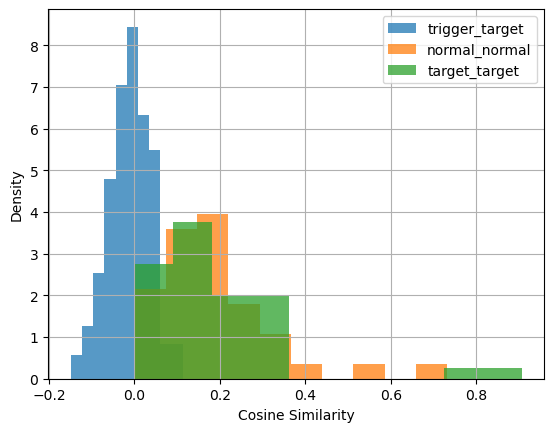

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties

def to_percent(y,position):
    return str(100*y)+"%"#这里可以用round（）函数设置取几位小数
'''
Edge similarity plot
'''
print("trigger_trigger_edge_sims",len(trigger_trigger_edge_sims))
print("trigger_target_edge_sims",len(trigger_target_edge_sims))
print("normal_normal_edge_sims",len(normal_normal_edge_sims))
print("trigger_normal_edge_sims",len(trigger_normal_edge_sims))
print("target_target_edge_sims",len(target_target_edge_sims))
if(len(trigger_trigger_edge_sims)!=0):
    plt.hist(trigger_trigger_edge_sims,bins=10,weights=[1./len(trigger_trigger_edge_sims)]*len(trigger_trigger_edge_sims),density=True, alpha=0.75, label='trigger_trigger')#这里weights是每一个数据的权重，这里设置是1，weights是和x等维的列表或者series
if(len(trigger_target_edge_sims)!=0):
    plt.hist(trigger_target_edge_sims,bins=10,weights=[1./len(trigger_target_edge_sims)]*len(trigger_target_edge_sims),density=True, alpha=0.75, label='trigger_target')#这里weights是每一个数据的权重，这里设置是1，weights是和x等维的列表或者series
plt.hist(normal_normal_edge_sims,bins=10,weights=[1./len(normal_normal_edge_sims)]*len(normal_normal_edge_sims),density=True, alpha=0.75, label='normal_normal')#这里weights是每一个数据的权重，这里设置是1，weights是和x等维的列表或者series
if(len(trigger_normal_edge_sims)!=0):
    plt.hist(trigger_normal_edge_sims,bins=10,weights=[1./len(trigger_normal_edge_sims)]*len(trigger_normal_edge_sims),density=True, alpha=0.75, label='trigger_normal')#这里weights是每一个数据的权重，这里设置是1，weights是和x等维的列表或者series
if(len(target_target_edge_sims)!=0):
    plt.hist(target_target_edge_sims,bins=10,weights=[1./len(target_target_edge_sims)]*len(target_target_edge_sims),density=True, alpha=0.75, label='target_target')#这里weights是每一个数据的权重，这里设置是1，weights是和x等维的列表或者series
fomatter=FuncFormatter(to_percent)
fomatter=FuncFormatter(to_percent)
# plt.gca().yaxis.set_major_formatter(fomatter)
plt.grid(True)
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
# plt.savefig("pics/grb_cora_node_sims.png")
# plt.savefig("pics/grb_cora_node_sims.pdf")
plt.show()
plt.close()

In [4]:
import torch.nn.functional as F
def overall_similarity_distribution(args,x,edge_index,edge_weights,device,large_graph=True):
    if(edge_weights==None):
        edge_weights = torch.ones([edge_index.shape[1]],device=device,dtype=torch.float)
    edge_index = edge_index[:,edge_weights>0.0].to(device).clone().detach()
    edge_weights = edge_weights[edge_weights>0.0].to(device).clone().detach()
    x = x.to(device).clone().detach()

    # bkd_test_edge_index = bkd_dr_test.data['mat_adj'].nonzero()
    trigger_trigger_edge_sims = []
    trigger_trigger_edge_index = []

    trigger_target_edge_sims = []
    trigger_target_edge_index = []

    normal_normal_edge_sims = []
    normal_normal_edge_index = []

    trigger_normal_edge_sims = []
    trigger_normal_edge_index = []

    target_target_edge_sims = []
    target_target_edge_index = []

    if(large_graph):
        edge_sims = torch.tensor([],dtype=float).cpu()
        N = edge_index.shape[1]
        num_split = 100
        N_split = int(N/num_split)
        for i in range(num_split):
            if(i == num_split-1):
                edge_sim1 = F.cosine_similarity(x[edge_index[0][N_split * i:]],x[edge_index[1][N_split * i:]]).cpu()
            else:
                edge_sim1 = F.cosine_similarity(x[edge_index[0][N_split * i:N_split*(i+1)]],x[edge_index[1][N_split * i:N_split*(i+1)]]).cpu()
            # print(edge_sim1)
            edge_sim1 = edge_sim1.cpu()
            edge_sims = torch.cat([edge_sims,edge_sim1])
        # edge_sims = edge_sims.to(device)
    else:
        edge_sims = F.cosine_similarity(x[edge_index[0]],x[edge_index[1]])
    return edge_sims
overall_edge_sims = overall_similarity_distribution(args,data.x,data.edge_index,None,device,large_graph=True)
overall_edge_sims1 = overall_similarity_distribution(args,poison_x,poison_edge_index,poison_edge_weights,device,large_graph=True)
overall_edge_sims2 = overall_similarity_distribution(args,induct_x,induct_edge_index,induct_edge_weights,device,large_graph=True)

trigger_trigger_edge_sims 10556


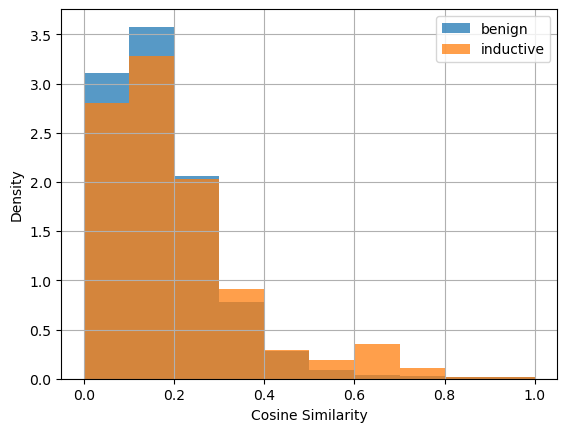

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties

def to_percent(y,position):
    return str(100*y)+"%"#这里可以用round（）函数设置取几位小数
'''
Edge similarity plot
'''
print("trigger_trigger_edge_sims",len(overall_edge_sims))
if(len(overall_edge_sims)!=0):
    plt.hist(overall_edge_sims,bins=10,weights=[1./len(overall_edge_sims)]*len(overall_edge_sims),density=True, alpha=0.75, label='benign')#这里weights是每一个数据的权重，这里设置是1，weights是和x等维的列表或者series
# if(len(overall_edge_sims1)!=0):
#     plt.hist(overall_edge_sims1,bins=10,weights=[1./len(overall_edge_sims1)]*len(overall_edge_sims1),density=True, alpha=0.75, label='poison')#这里weights是每一个数据的权重，这里设置是1，weights是和x等维的列表或者series
if(len(overall_edge_sims2)!=0):
    plt.hist(overall_edge_sims2,bins=10,weights=[1./len(overall_edge_sims2)]*len(overall_edge_sims2),density=True, alpha=0.75, label='inductive')#这里weights是每一个数据的权重，这里设置是1，weights是和x等维的列表或者series
fomatter=FuncFormatter(to_percent)
# plt.gca().yaxis.set_major_formatter(fomatter)
plt.grid(True)
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
# plt.savefig("pics/grb_cora_node_sims.png")
# plt.savefig("pics/grb_cora_node_sims.pdf")
plt.show()
plt.close()